**TODO**
- hyper parameter tunning
    - [ ] lr, batch_size, lambdas
    - [ ] .sh -> config -> Tensorboard에서 쉽게 확인할 수 있게 저장
- Callbacks <- tape. X
    - [x] Tensorboad - img, loss.
    - [x] EarlyStopping - 종료조건?
    - [x] ModelCheckpoint - per epoch
- Tensorflow 2.0b1
    - [ ] dataset -> for
    - [ ] Gradient Tape    
    - [ ] @tf.function

훈련 루프

- [x] print_status_bar(iteration: 현재 스텝, total: 총 스텝, loss: 현재 스텝의 로스, metrics=None)
- [x] metrics: [keras.metrics.Mean]


1. [x] epochs loop
2. [x] dataset loop
3. [x] with gradientTape

### Tensorboard

https://www.tensorflow.org/tensorboard/r2/scalars_and_keras

1. file writer 생성
2. with train_summary_writer.as_default() - context manager
3. tf.summary.scalar...image..
4. metric 관리 -> train_loss.result(), reset

In [1]:
import tensorflow as tf
import importlib
from pprint import pprint
import matplotlib.pyplot as plt
from PIL import Image
keras = tf.keras
K =keras.backend

# reload needed
import data.data_generator as data_generator
import models.dc as dc
import models.generator as generator
import config

# reloading
importlib.reload(config)
importlib.reload(data_generator)
importlib.reload(dc)
importlib.reload(generator)

pprint(config.BaseConfig.__dict__)
config = config.DockerConfig
pprint(config.__dict__)

print(tf.__version__)

mappingproxy({'__dict__': <attribute '__dict__' of 'BaseConfig' objects>,
              '__doc__': None,
              '__module__': 'config',
              '__weakref__': <attribute '__weakref__' of 'BaseConfig' objects>,
              'batch_size': 128,
              'epochs': 200,
              'filepath': '../data/output_dir/models_001',
              'img_dir': '../data/CelebA/img_align_celeba',
              'label_path': '../data/CelebA/Anno/list_attr_celeba.txt',
              'lambda_L_cls_c': 1.0,
              'lambda_L_cls_g': 1.0,
              'lambda_L_rec': 100.0,
              'leaky_relu_alpha': 0.3,
              'learning_rate': 0.0001,
              'log_dir': '../data/output_dir',
              'n_val': 1,
              'num_attr': 13,
              'update_freq': 10,
              'verbose': 1})
mappingproxy({'__doc__': None,
              '__module__': 'config',
              'filepath': '/tf/data/output_dir/models_001',
              'img_dir': '/tf/data/CelebA

In [2]:
mean_squared_error = keras.losses.mean_squared_error
mean_absolute_error = keras.losses.mean_absolute_error
binary_crossentropy = keras.losses.binary_crossentropy
mean_absolute_error = keras.losses.mean_absolute_error
Adam = keras.optimizers.Adam


In [11]:
# @tf.function
def train_step(models, inputs, optimizers, metrics, config: config):
    """
    AttGAN train step
    models: generator, discriminator
    
    :return: metrics, preds
    """
    g, d = models
    xa, a, b = inputs
    opt_g, opt_d = optimizers
    losses = {}
    preds = None # imgs
    
    ## train discriminator ##
    with tf.GradientTape() as tape:
        # loss_cls
        # loss_adv
        _, xb_ = g(inputs)
        probs_d, probs_c = d(inputs=(xa, xb_))
        (d_xa, d_xb_), (c_xa, c_xb_) = probs_d, probs_c
        
#         loss_adv = mean_squared_error(K.flatten(K.ones_like(d_xa)), K.flatten(d_xa)) + mean_squared_error(K.flatten(K.zeros_like(d_xb_)), K.flatten(d_xb_))
        loss_adv = binary_crossentropy(K.flatten(K.ones_like(d_xa)), K.flatten(d_xa)) + binary_crossentropy(K.flatten(K.zeros_like(d_xb_)), K.flatten(d_xb_))
        loss_cls = binary_crossentropy(K.flatten(a), K.flatten(c_xa), from_logits=False) * config.lambda_L_cls_c
        
        
        loss = loss_adv + loss_cls
        losses = {**losses,
            'loss_adv_d': loss_adv,
            'loss_cls_d': loss_cls,
            'loss_d': loss
        }
#         print(f'loss: {loss.numpy(): 10.5f}')
#         print(f'loss_adv_d: {loss_adv.numpy(): 10.5f}')
#         print(f'loss_cls_d: {loss_cls.numpy(): 10.5f}')
        
    grads = tape.gradient(target=loss, sources=d.trainable_variables)
    opt_d.apply_gradients(zip(grads, d.trainable_variables))

        
        
    ## train generator ##
    with tf.GradientTape() as tape:
        
        xa_, xb_ = g(inputs)
        preds = xa_, xb_
        probs_d, probs_c = d(inputs=(xa, xb_))
        (_, d_xb_), (_, c_xb_) = probs_d, probs_c

        loss_rec = mean_absolute_error(K.flatten(xa_), K.flatten(xa)) * config.lambda_L_rec
        loss_cls = binary_crossentropy(K.flatten(b), K.flatten(c_xb_), from_logits=False) * config.lambda_L_cls_g
#         loss_adv = mean_squared_error(K.flatten(K.ones_like(d_xb_)), K.flatten(d_xb_))
        loss_adv = binary_crossentropy(K.flatten(K.ones_like(d_xb_)), K.flatten(d_xb_))

        
        loss = loss_rec + loss_cls + loss_adv
        
        losses = {**losses,
            'loss_rec_g': loss_rec,
            'loss_adv_g': loss_adv,
            'loss_cls_g': loss_cls,
            'loss_g': loss
        }
#         print(f'loss: {loss.numpy(): 10.5f}')
#         print(f'loss_rec: {loss_rec.numpy(): 10.5f}')
#         print(f'loss_adv_g: {loss_adv.numpy(): 10.5f}')
#         print(f'loss_cls_g: {loss_cls.numpy(): 10.5f}')
        
    grads = tape.gradient(target=loss, sources=g.trainable_variables)
    opt_g.apply_gradients(zip(grads, g.trainable_variables))
    
    for name, metric in metrics.items():
        metric(losses[name])
    
    return metrics, preds
    



In [12]:
def val_step(models, inputs, metrics, config: config):
    
    g, d = models
    xa, a, b = inputs
    losses = {}
    preds = None # imgs
    
    ## Discriminator ##
    _, xb_ = g(inputs)
    probs_d, probs_c = d(inputs=(xa, xb_))
    (d_xa, d_xb_), (c_xa, c_xb_) = probs_d, probs_c

#   loss_adv = mean_squared_error(K.flatten(K.ones_like(d_xa)), K.flatten(d_xa)) + mean_squared_error(K.flatten(K.zeros_like(d_xb_)), K.flatten(d_xb_))
    loss_adv = binary_crossentropy(K.flatten(K.ones_like(d_xa)), K.flatten(d_xa)) + binary_crossentropy(K.flatten(K.zeros_like(d_xb_)), K.flatten(d_xb_))
    loss_cls = binary_crossentropy(K.flatten(a), K.flatten(c_xa), from_logits=False) * config.lambda_L_cls_c
    
    loss = loss_adv + loss_cls
    losses = {**losses,
        'loss_adv_d': loss_adv,
        'loss_cls_d': loss_cls,
        'loss_d': loss
    }
    ## Generator ##
    xa_, xb_ = g(inputs)
    preds = xa_, xb_
    
    probs_d, probs_c = d(inputs=(xa, xb_))
    (_, d_xb_), (_, c_xb_) = probs_d, probs_c

    loss_rec = mean_absolute_error(K.flatten(xa_), K.flatten(xa)) * config.lambda_L_rec
    loss_cls = binary_crossentropy(K.flatten(b), K.flatten(c_xb_), from_logits=False) * config.lambda_L_cls_g
#   loss_adv = mean_squared_error(K.flatten(K.ones_like(d_xb_)), K.flatten(d_xb_))
    loss_adv = binary_crossentropy(K.flatten(K.ones_like(d_xb_)), K.flatten(d_xb_))

    loss = loss_rec + loss_cls + loss_adv
    losses = {**losses,
        'loss_rec_g': loss_rec,
        'loss_adv_g': loss_adv,
        'loss_cls_g': loss_cls,
        'loss_g': loss
    }
    
    for name, metric in metrics.items():
        metric(losses[name])
    
    return metrics, preds
    

In [13]:
def print_status_bar(step, epoch, metrics, end='\r'):
    """
    스텝 상태바
    """
    print(f"== Epoch:{epoch: 3d},Step:{step: 5d},\
          loss_g: {metrics['loss_g'].result(): 5.5f},\
          loss_d: {metrics['loss_d'].result(): 5.5f}==", end=end)

In [14]:
def _demap_fn(x):
    """
    이미지 denormalize
    """
    x = tf.math.multiply(x, 127.5)
    x = tf.math.add(x, 127.5)
    x = tf.cast(x, tf.uint8)
    return x

In [15]:
def write_summary(writer, metrics, preds, step):
    """
    텐서보드에 기록
    :return: None
    """
    with writer.as_default():
        # metrics
        for name, metric in metrics.items():
            tf.summary.scalar(name=f'{name}', data=metric.result(), step=step)
        # images
        xa_, xb_ = preds
        tf.summary.image(name=f'xa_', data=_demap_fn(xa_), step=step)
        tf.summary.image(name=f'xb_', data=_demap_fn(xb_), step=step)

In [16]:
dataset = data_generator.dataGenerator(config)
dataset_train, dataset_val = dataset.get_dataset()  # dataset_val만 iterator 임!
xa_val, a_val, b_val = next(dataset_val)

n_train: 202598
n_val: 1
loading labels...
loading dataset..


In [17]:
config.log_dir

'/tf/data/output_dir'

model: Generator 생성됨
layer: Encoder 생성됨
layer: Injector 생성됨
layer: Decoder 생성됨
model: Disciminator 생성됨
layer: Common 생성됨
layer: Discriminator 생성됨
layer: Classifier 생성됨
n_train: 202598
n_val: 1
loading labels...
loading dataset..

validation img


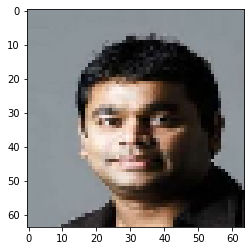


Generating new dataset...
n_train: 202598
n_val: 1
loading labels...
loading dataset..
Epoch: 0/200


In [ ]:
metrics_train = {
    'loss_g': keras.metrics.Mean(),
    'loss_d': keras.metrics.Mean(),
    'loss_adv_d': keras.metrics.Mean(),
    'loss_adv_g': keras.metrics.Mean(),
    'loss_cls_d': keras.metrics.Mean(),
    'loss_cls_g': keras.metrics.Mean(),
    'loss_rec_g': keras.metrics.Mean(),
}

metrics_val = {
    'loss_g': keras.metrics.Mean(),
    'loss_d': keras.metrics.Mean(),
    'loss_adv_d': keras.metrics.Mean(),
    'loss_adv_g': keras.metrics.Mean(),
    'loss_cls_d': keras.metrics.Mean(),
    'loss_cls_g': keras.metrics.Mean(),
    'loss_rec_g': keras.metrics.Mean(),
}
# training loop
g = generator.Generator(name='Generator')
d = dc.DC(name='Disciminator')

config.learning_rate = 0.0001
config.lambda_L_rec = 10.0

opt_g = Adam(learning_rate=config.learning_rate, beta_1=0.5)
opt_d = Adam(learning_rate=config.learning_rate, beta_1=0.5)

writer_train = tf.summary.create_file_writer(config.log_dir + '/train/190806-1-0.0001/rec10')
writer_val = tf.summary.create_file_writer(config.log_dir + '/val/190806-1-0.0001/rec10')

dataset = data_generator.dataGenerator(config)
_, dataset_val = dataset.get_dataset()  # dataset_val만 iterator 임!
print(f'\nvalidation img')
xa_val, a_val, b_val = next(dataset_val)
plt.imshow(_demap_fn(xa_val.numpy()[0]))
plt.show()

for epoch in range(config.epochs):
    print(f'\nGenerating new dataset...')
    dataset_train, _ = dataset.get_dataset()  # dataset_val만 iterator 임!
    
    steps_per_epoch = dataset.get_steps_per_epoch()
    
    print(f'Epoch:{epoch: 2d}/{config.epochs}')
    for (step, (xa, a, b)) in enumerate(dataset_train):

        global_step = epoch * steps_per_epoch + step
        # train step
        metrics_train, preds_train = train_step((g, d), (xa, a, b), (opt_g, opt_d), metrics_train, config)

        # status bar
        print_status_bar(step, epoch, metrics_train)
        
#         print('==original==')
#         plt.imshow(_demap_fn(xa.numpy()[0]))
#         plt.show()
#         print('==preds==')
#         plt.imshow(_demap_fn(preds_train[0].numpy()[0]))
#         plt.show()
        
        if global_step % 10 == 0:
            for i in range(config.n_val // config.batch_size + 1):
                
                metrics_val, preds_val = val_step((g, d), (xa_val, a_val, b_val), metrics_val, config)
                write_summary(writer_train, metrics_train, preds_train, step=global_step)
                write_summary(writer_val, metrics_val, preds_val, step=global_step)
        
    for name, metric in metrics_train.items():
        metric.reset_states()
    for name, metric in metrics_val.items():
        metric.reset_states()
        # print_status_bar - per step
    # print_status_bar - per epoch
    
    # metric reset
    
    